# Amazon: 20 years of reviews

In [102]:
import numpy as np
import pandas as pd
import pickle

import collections
%matplotlib inline

In [2]:
# directory where you have the parquet files. You need them to run any analysis.
# Download Parquets here: https://drive.google.com/open?id=1BkH7vfupcBaLs2gTYphff6z9Qvg-TcAq
# Extract parquet.tar.gz to the directory of you notebook or change the PARQUET_DIR
PARQUET_DIR = './parquet/'

In [3]:
# Load dataframes listing the parquet files

#US reviews by category
with open('category_reviews.pickle', 'rb') as file:
    category_reviews = pickle.load(file)

# International reviews, by country
with open('multilingual_reviews.pickle', 'rb') as file:
    multilingual_reviews = pickle.load(file)

These dataframes list parquet filenames to access the data. It is not possible to load them all, as you will run into memory problems. Therefore, they must be analysed one by one.

Working on a single category (or country) is straightforward.

In [4]:
category_reviews

,filename,parquet,category
0,amazon_reviews_us_Shoes_v1_00.tsv.gz,amazon_reviews_us_Shoes_v1_00.parquet.gzip,Shoes
1,amazon_reviews_us_Mobile_Apps_v1_00.tsv.gz,amazon_reviews_us_Mobile_Apps_v1_00.parquet.gzip,Mobile_Apps
2,amazon_reviews_us_Personal_Care_Appliances_v1_...,amazon_reviews_us_Personal_Care_Appliances_v1_...,Personal_Care_Appliances
3,amazon_reviews_us_Home_Improvement_v1_00.tsv.gz,amazon_reviews_us_Home_Improvement_v1_00.parqu...,Home_Improvement
4,amazon_reviews_us_Digital_Video_Download_v1_00...,amazon_reviews_us_Digital_Video_Download_v1_00...,Digital_Video_Download
5,amazon_reviews_us_Kitchen_v1_00.tsv.gz,amazon_reviews_us_Kitchen_v1_00.parquet.gzip,Kitchen
6,amazon_reviews_us_Electronics_v1_00.tsv.gz,amazon_reviews_us_Electronics_v1_00.parquet.gzip,Electronics
7,amazon_reviews_us_Digital_Music_Purchase_v1_00...,amazon_reviews_us_Digital_Music_Purchase_v1_00...,Digital_Music_Purchase
8,amazon_reviews_us_Video_v1_00.tsv.gz,amazon_reviews_us_Video_v1_00.parquet.gzip,Video
9,amazon_reviews_us_Musical_Instruments_v1_00.ts...,amazon_reviews_us_Musical_Instruments_v1_00.pa...,Musical_Instruments


In [5]:
multilingual_reviews.head()

,filename,parquet,country
3,amazon_reviews_multilingual_US_v1_00.tsv.gz,amazon_reviews_multilingual_US_v1_00.parquet.gzip,US
14,amazon_reviews_multilingual_FR_v1_00.tsv.gz,amazon_reviews_multilingual_FR_v1_00.parquet.gzip,FR
27,amazon_reviews_multilingual_UK_v1_00.tsv.gz,amazon_reviews_multilingual_UK_v1_00.parquet.gzip,UK
36,amazon_reviews_multilingual_JP_v1_00.tsv.gz,amazon_reviews_multilingual_JP_v1_00.parquet.gzip,JP
39,amazon_reviews_multilingual_DE_v1_00.tsv.gz,amazon_reviews_multilingual_DE_v1_00.parquet.gzip,DE


In [6]:
# An example review set is loaded as follows:
df_shoes = pd.read_parquet(PARQUET_DIR + category_reviews[category_reviews.category == 'Shoes'].loc[0]['parquet'])
df_shoes.head()

,customer_id,review_id,product_parent,product_category,star_rating,helpful_votes,total_votes,review_date
0,18069663,R3P2HIOQCIN5ZU,265024781,Shoes,1,0,0,2015-08-31
1,16251825,R12VVR0WH5Q24V,259035853,Shoes,5,0,0,2015-08-31
2,20381037,RNCCKB6TV5EEF,666066660,Shoes,4,0,0,2015-08-31
3,108364,R2NZXYIVCGB13W,448483263,Shoes,5,0,6,2015-08-31
4,45449350,R2EQ1TG9IT3OEQ,7853171,Shoes,3,0,0,2015-08-31


In [87]:
df_shoes.shape[0]

4366761

# Temporal evolution

First insight of Amazon's growth during the last two decades

In [9]:
# How the number of reviews evolved over time
# Let's first focus on the Book's category
df_books = pd.read_parquet(PARQUET_DIR + category_reviews[category_reviews.category == 'Books'].loc[41]['parquet'])
df_books.head()

,customer_id,review_id,product_parent,product_category,star_rating,helpful_votes,total_votes,review_date
0,25933450,RJOVP071AVAJO,84656342,Books,5,0,0,2015-08-31
1,1801372,R1ORGBETCDW3AI,729938122,Books,5,0,0,2015-08-31
2,5782091,R7TNRFQAOUTX5,678139048,Books,5,0,0,2015-08-31
3,32715830,R2GANXKDIFZ6OI,712432151,Books,5,0,0,2015-08-31
4,14005703,R2NYB6C3R8LVN6,800572372,Books,5,2,2,2015-08-31


Text(0, 0.5, 'Number of Reviews')

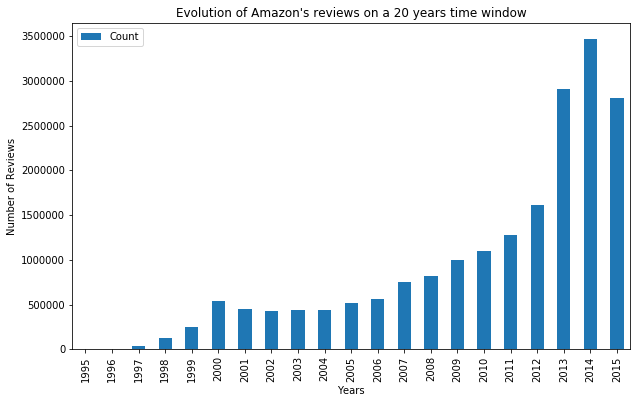

In [101]:
df_books['year'] = pd.DatetimeIndex(df_books['review_date']).year

# Count the review per year and plot the result
counter=collections.Counter(df_books['year'])

df_year_reviews = pd.DataFrame(counter, index=[0]).transpose().sort_index(axis=0)
df_year_reviews.columns = ["Count"]
ax=df_year_reviews.plot(kind='bar', figsize=(10,6), title="Evolution of Amazon's reviews on a 20 years time window")

ax.set_xlabel("Years")
ax.set_ylabel("Number of Reviews")

# Sample analysis

Let's count reviews per category.

In [13]:
def count_reviews(parquet_file):
    """
    Counts reviews from specified file
    """
    df = pd.read_parquet(PARQUET_DIR + parquet_file)
    return df.shape[0]

In [14]:
category_reviews['review_count'] = category_reviews['parquet'].apply(count_reviews)
category_reviews

,filename,parquet,category,review_count
0,amazon_reviews_us_Shoes_v1_00.tsv.gz,amazon_reviews_us_Shoes_v1_00.parquet.gzip,Shoes,4366761
1,amazon_reviews_us_Mobile_Apps_v1_00.tsv.gz,amazon_reviews_us_Mobile_Apps_v1_00.parquet.gzip,Mobile_Apps,5033305
2,amazon_reviews_us_Personal_Care_Appliances_v1_...,amazon_reviews_us_Personal_Care_Appliances_v1_...,Personal_Care_Appliances,85978
3,amazon_reviews_us_Home_Improvement_v1_00.tsv.gz,amazon_reviews_us_Home_Improvement_v1_00.parqu...,Home_Improvement,2634428
4,amazon_reviews_us_Digital_Video_Download_v1_00...,amazon_reviews_us_Digital_Video_Download_v1_00...,Digital_Video_Download,4056597
5,amazon_reviews_us_Kitchen_v1_00.tsv.gz,amazon_reviews_us_Kitchen_v1_00.parquet.gzip,Kitchen,4880210
6,amazon_reviews_us_Electronics_v1_00.tsv.gz,amazon_reviews_us_Electronics_v1_00.parquet.gzip,Electronics,3093750
7,amazon_reviews_us_Digital_Music_Purchase_v1_00...,amazon_reviews_us_Digital_Music_Purchase_v1_00...,Digital_Music_Purchase,1688652
8,amazon_reviews_us_Video_v1_00.tsv.gz,amazon_reviews_us_Video_v1_00.parquet.gzip,Video,380576
9,amazon_reviews_us_Musical_Instruments_v1_00.ts...,amazon_reviews_us_Musical_Instruments_v1_00.pa...,Musical_Instruments,904716


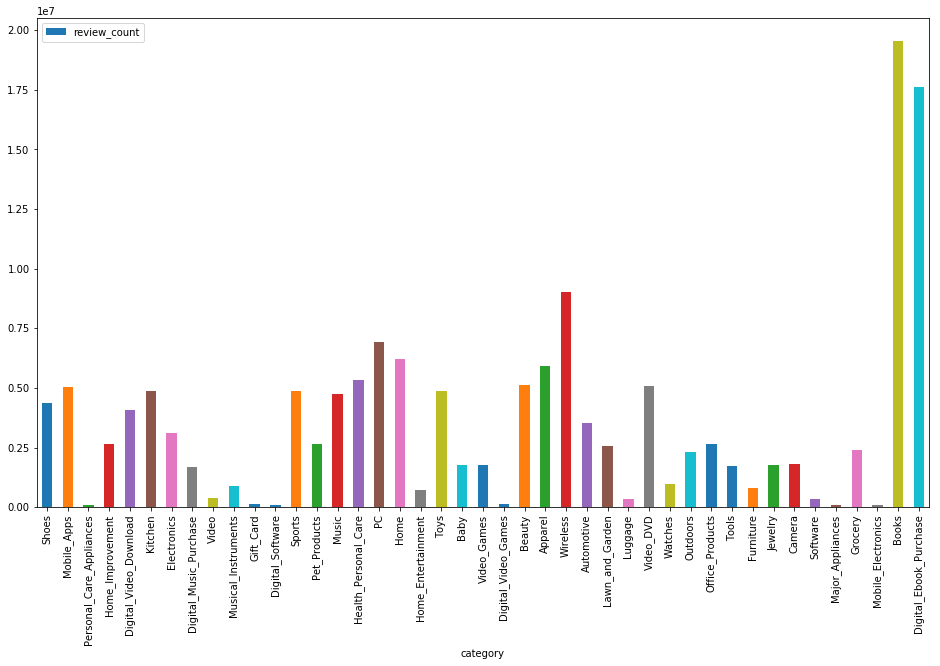

In [10]:
category_reviews.plot.bar(x='category', y='review_count', figsize=(16,9))

# Notes

The parquet files can also be read by pyspark in the following manner:

```
df = sql_context.read.parquet(PARQUET_DIR + row['parquet'])
```

Don't forget about importing pyspark before using it:

```
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DateType

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
sql_context = SQLContext(sc)
```

If kernel dies repetadly, using del(df) might help, for instance in this way (not tested):

```
def count_reviews_with_del(parquet_file):
    """
    Counts reviews from specified file
    """
    df = pd.read_parquet(PARQUET_DIR + parquet_file)
    length = df.shape[0]
    del(df)
    return length
```